In [1]:
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from torchvision.ops.boxes import box_iou

In [2]:
class PRCurveDrawer:
    def __init__(self,
        data_file: str=r'//aka/work/hara.e/AMED/lib/dataset/annotations/test.json',
        preds_file: str=r'//aka/work/hara.e/AMED/YOLOX/YOLOX_outputs/amed/preds.json',
    ):
        with open(preds_file) as f:
            self.preds = json.load(f)
        with open(data_file) as f:
            self.data = json.load(f)['annotations']
            
        self.re_ths = [th / 100 for th in range(1, 95)]
        self.ious = self._get_ious()
        self.reliabilities = self.preds['reliability']
        self.items = {'iou': self.ious, 'reliability': self.reliabilities}

    def draw(self, iou_th: list=[0.5]):
        self.iou_th = iou_th
        plt.axis('square')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        
        for th in self.iou_th:
            precision, recall = self._get_pr(th)
            plt.plot([recall[0]] + recall, [0.0] + precision)

        plt.legend(self.iou_th, title='IoU')
        plt.xlabel('Recall')
        plt.ylabel('Precision')

    def _get_pr(self, iou_th: int) -> (list, list):
        precision, recall = [], []
        for re_th in self.re_ths:
            correct = 0
            for iou, re in zip(self.ious, self.reliabilities):
                for i, r in zip(iou, re):
                    if (i > iou_th) and (r > re_th):
                        correct += 1
            recall += [correct / len(self.ious)]
            precision += [correct / sum([1 for re in self.reliabilities for r in re if r > re_th])]
        return precision, recall
            
    def _get_ious(self) -> list:
        ious = []
        for i, pred in enumerate(self.preds['annotations']):
            iou = PRCurveDrawer._calc_iou(self.preds['annotations'][i], self.data[i]['bbox'])
            ious += [iou]
        return ious

    @staticmethod
    def _calc_iou(pred: list, label: list) -> list:
        x, y, w, h = label
        if pred is not None:
            iou = box_iou(torch.Tensor(pred['bbox']), torch.Tensor([[x, y, x + w, y + h]]))
        else:
            iou = torch.Tensor([[0.]])
        return iou.flatten().tolist()

# Draw PR-Curve

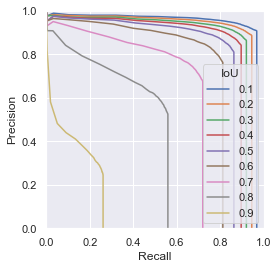

In [3]:
drawer = PRCurveDrawer()
drawer.draw(iou_th = [th / 10 for th in range(1, 10)])

# Show Some Data

In [4]:
import pandas as pd

df = pd.DataFrame(drawer.items)
df.head()

,iou,reliability
0,[0.6355545520782471],[0.8948855803197375]
1,[0.6460248827934265],[0.5881655878609351]
2,[0.4510451555252075],[0.8563984866902068]
3,[0.08195419609546661],[0.8752405576362463]
4,[0.45758599042892456],[0.8548910803488958]


In [5]:
df.iloc[[30], :]

,iou,reliability
30,"[0.6313917636871338, 0.0]","[0.8669306324708117, 0.4032978270025822]"


In [6]:
df.iloc[[44], :]

,iou,reliability
44,[0.0],[0.43404865590756003]
